In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    _path = os.getcwd().replace("/notebooks", "")
else:
    assert os.getcwd().endswith("receipts-xyz-python")
    _path = os.getcwd()

if _path not in sys.path:
    sys.path.append(_path)

In [203]:
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from receipts_xyz.v2.onchainsummer import get_onchainsummer_workouts

## Load Dataset

In [36]:
TIMEZONE = "US/Eastern"
csv_path = "onchainsummer.csv"

if not os.path.exists(csv_path):
    # fetch data if not exists
    workouts = get_onchainsummer_workouts()
    df = pd.DataFrame([_w.to_json() for _w in workouts])
    
    use_col = [
        "time",
        "total_participants", "total_moving_time", "total_run_distance", 
        "total_bike_distance", "total_strength_time", "total_intensity_time"
    ]
    df = df[use_col]
    
    df.to_csv(csv_path, index=None)
else:
    df = pd.read_csv(csv_path)

df["datetime"] = df["time"].map(
    lambda x: datetime.fromtimestamp(x, tz=pytz.timezone(TIMEZONE))
)
df = df.drop("time", axis=1).set_index("datetime")

# resample to hourly unit
df = df.resample("h").max()


# get daily stats, df are cumulative
df_daily = df.diff(1).fillna(df).astype(int).rename(columns={
    "total_participants": "# new participant",
    "total_run_distance": "Run Distance (km)",
    "total_bike_distance": "Bike Distance (km)",
    "total_moving_time": "Moving Time (min)",
    "total_strength_time": "Strength Time (min)",
    "total_intensity_time": "Intensity Time (min)"
})
df_daily["Run Distance (km)"] = df_daily["Run Distance (km)"] / 1000
df_daily["Bike Distance (km)"] = df_daily["Bike Distance (km)"] / 1000
df_daily["Moving Time (min)"] = df_daily["Moving Time (min)"] // 60
df_daily["Strength Time (min)"] = df_daily["Strength Time (min)"] // 60
df_daily["Intensity Time (min)"] = df_daily["Intensity Time (min)"] // 60

In [37]:
df.head()

,total_participants,total_moving_time,total_run_distance,total_bike_distance,total_strength_time,total_intensity_time
datetime,,,,,,
2024-08-05 00:00:00-04:00,3,2866,14751,5643,0,6437
2024-08-05 01:00:00-04:00,6,5912,23921,5643,0,13826
2024-08-05 02:00:00-04:00,8,6862,29792,5643,950,16487
2024-08-05 03:00:00-04:00,11,7521,29792,5643,950,21563
2024-08-05 04:00:00-04:00,12,10015,29792,5643,3444,22924


## Analysis

In [38]:
num_workouts = len(df)

print(f"Total {num_workouts} workouts attested")

Total 168 workouts attested


### Boring plots

In [150]:
df.head()

,total_participants,total_moving_time,total_run_distance,total_bike_distance,total_strength_time,total_intensity_time
datetime,,,,,,
2024-08-05 00:00:00-04:00,3,2866,14751,5643,0,6437
2024-08-05 01:00:00-04:00,6,5912,23921,5643,0,13826
2024-08-05 02:00:00-04:00,8,6862,29792,5643,950,16487
2024-08-05 03:00:00-04:00,11,7521,29792,5643,950,21563
2024-08-05 04:00:00-04:00,12,10015,29792,5643,3444,22924


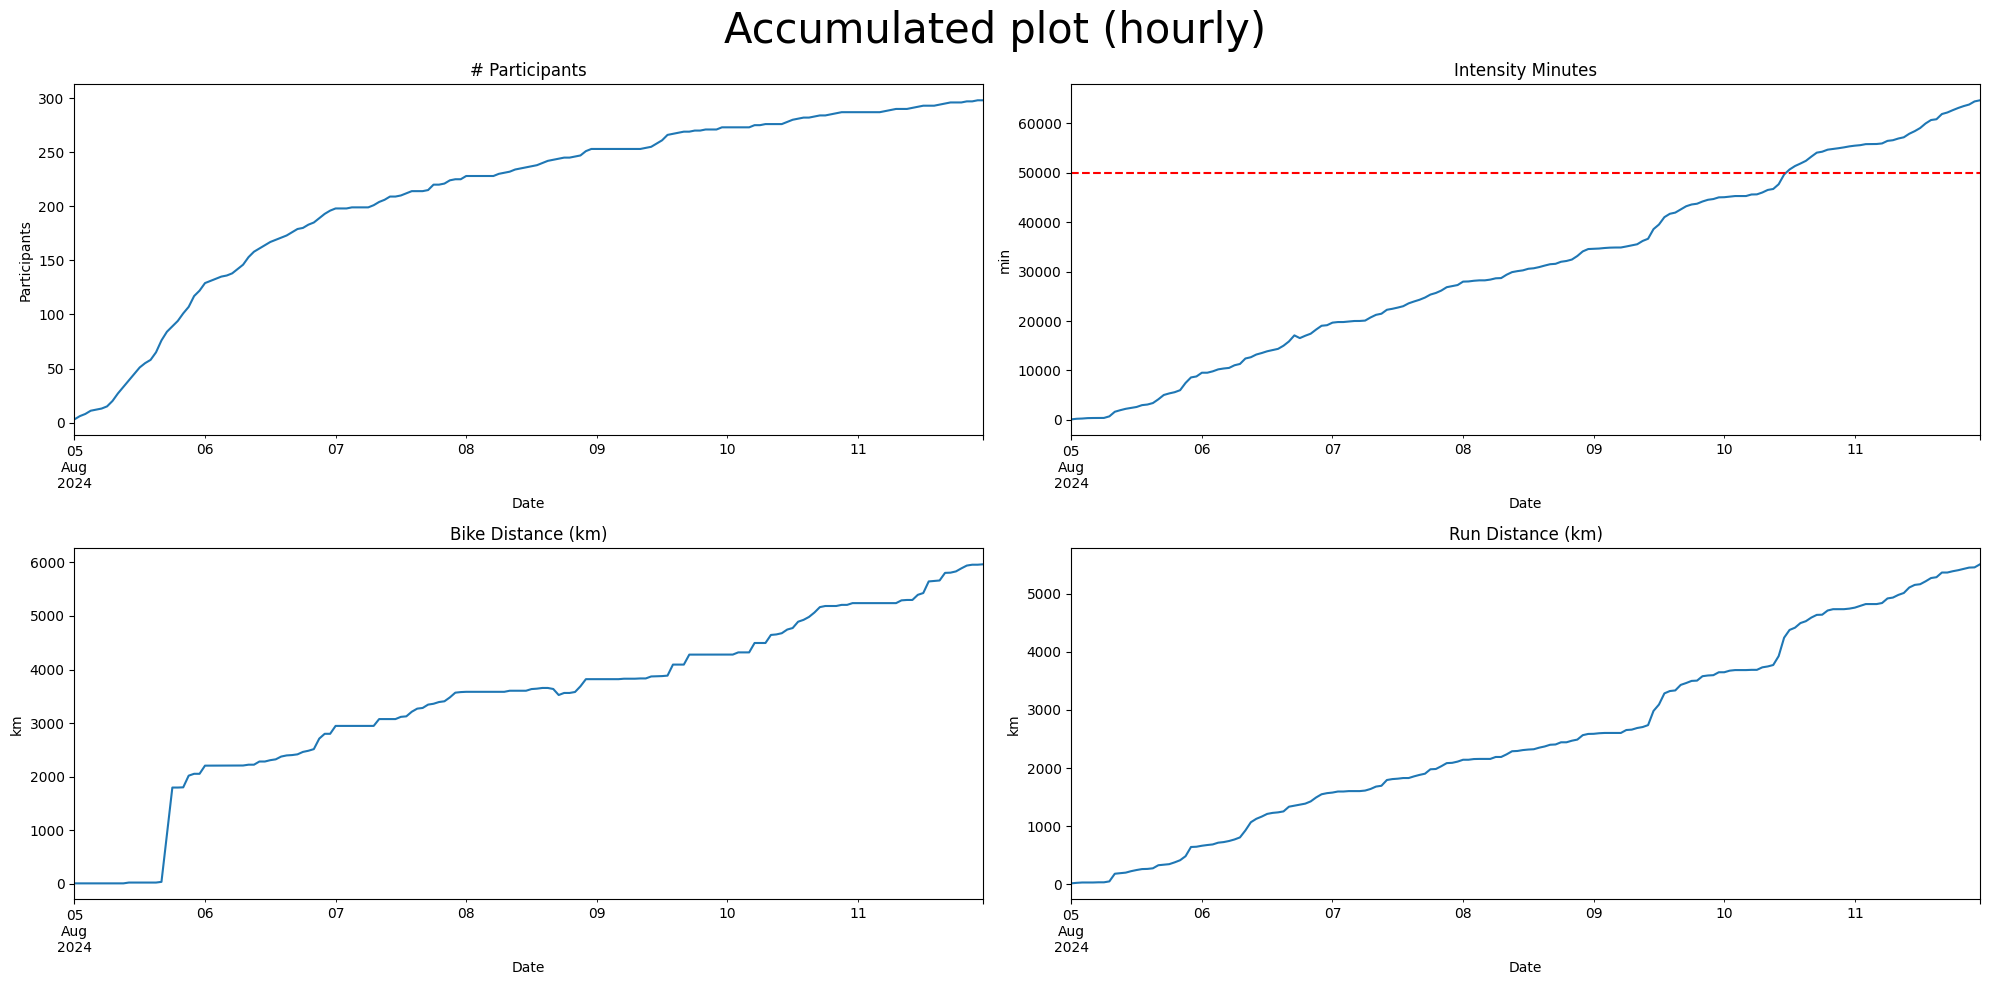

In [174]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

df.rename(columns={"total_participants": "# Particinpants"})["# Particinpants"].plot(
    title="# Participants", ax=ax[0][0]
)
ax[0][0].set_xlabel("Date")
ax[0][0].set_ylabel("Participants")

(df.rename(columns={"total_intensity_time": "Intensity Minutes"})["Intensity Minutes"] // 60).plot(
    title="Intensity Minutes", 
    ax=ax[0][1]
)
ax[0][1].axhline(50_000, color="red", linestyle="--")
ax[0][1].set_xlabel("Date")
ax[0][1].set_ylabel("min")


(
    df.rename(columns={"total_bike_distance": "Bike Distance (km)"})["Bike Distance (km)"] / \
    1000
).plot(
    title="Bike Distance (km)", ax=ax[1][0]
)
ax[1][0].set_xlabel("Date")
ax[1][0].set_ylabel("km")


(
    df.rename(columns={"total_run_distance": "Run Distance (km)"})["Run Distance (km)"] / \
    1000
).plot(
    title="Run Distance (km)", ax=ax[1][1]
)
ax[1][1].set_xlabel("Date")
ax[1][1].set_ylabel("km")

fig.suptitle("Accumulated plot (hourly)", fontsize=30)

fig.tight_layout()

### New participants vs contributed intensity minutes

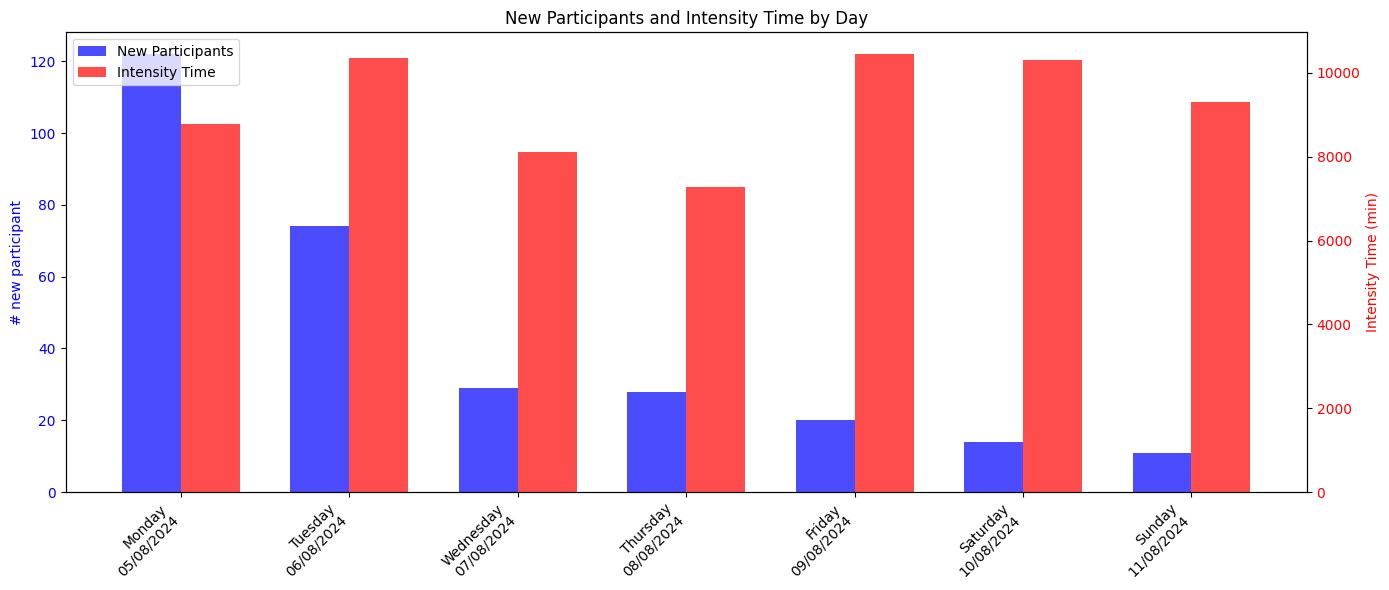

In [238]:
# Resample and sum the data
resampled_data = df_daily.resample("D").sum()[["# new participant", "Intensity Time (min)"]]

# Create the figure and the primary axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Set the width of each bar and the positions of the bars
width = 0.35
x = np.arange(len(resampled_data.index))

# Plot the '# new participant' on the primary axis
rects1 = ax1.bar(x - width/2, resampled_data["# new participant"], width, label='New Participants', color='b', alpha=0.7)
ax1.set_ylabel('# new participant', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary axis
ax2 = ax1.twinx()

# Plot the 'Intensity Time (min)' on the secondary axis
rects2 = ax2.bar(x + width/2, resampled_data["Intensity Time (min)"], width, label='Intensity Time', color='r', alpha=0.7)
ax2.set_ylabel('Intensity Time (min)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the x-axis ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(resampled_data.index.strftime("%A\n%d/%m/%Y"), rotation=45, ha='right')

# Set the title and adjust the layout
plt.title('New Participants and Intensity Time by Day')
fig.tight_layout()

# Add a legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.show()

### Strength Training Ratio

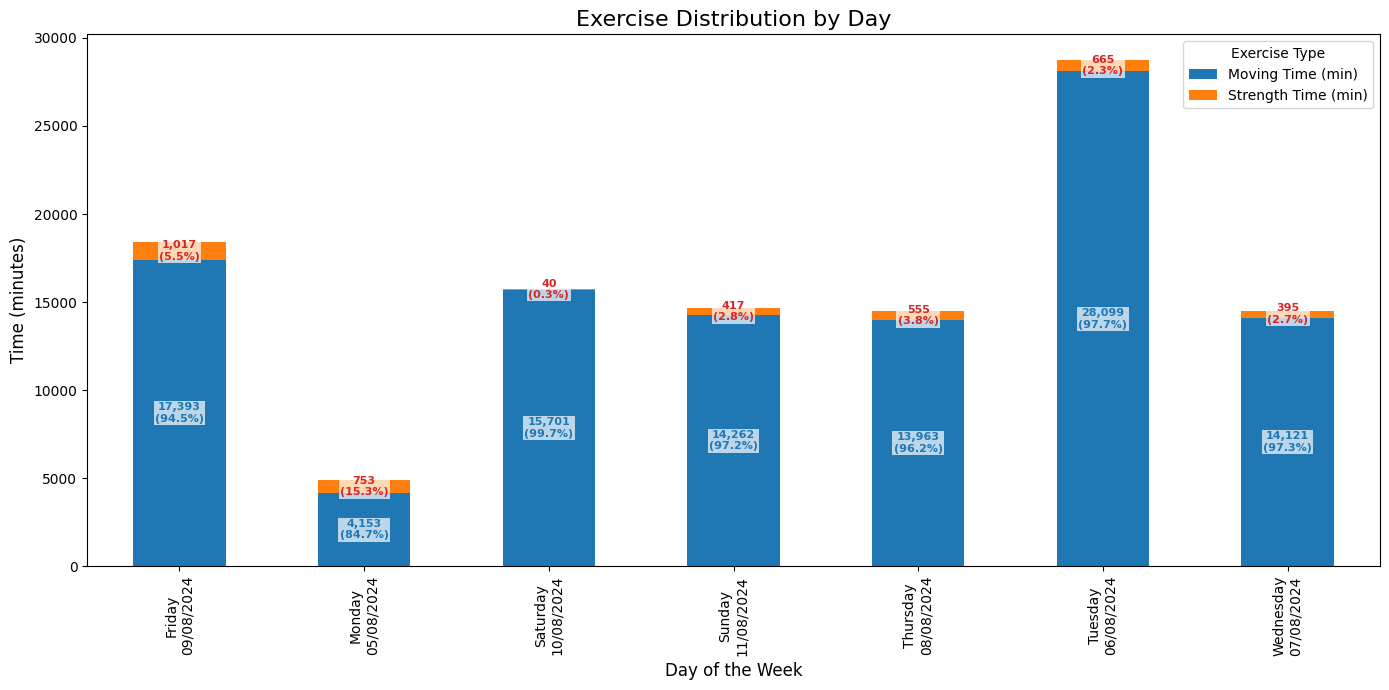

In [91]:
# Resample and prepare the data
df_plot = df_daily.resample("D").sum().drop("Intensity Time (min)", axis=1).set_index(
    df_daily.resample("D").sum().index.strftime("%A\n%d/%m/%Y")
)[["Moving Time (min)", "Strength Time (min)"]].sort_index()

# Adjust Moving Time to exclude Strength Time
df_plot["Moving Time (min)"] -= df_plot["Strength Time (min)"]

# Calculate total time for each day (for percentage calculation)
df_plot['Total'] = df_plot.sum(axis=1)

# Create the bar plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = df_plot[["Moving Time (min)", "Strength Time (min)"]].plot.bar(ax=ax, stacked=True)

# Define colors for text (darker for better contrast)
colors = ['#1f77b4', '#d62728']  # Dark blue and dark red

# Function to create label text
def make_label(val, total):
    minutes = int(val)
    percentage = (val / total) * 100
    return f'{minutes:,}\n({percentage:.1f}%)'

# Add labels on each bar segment with improved readability
for i, container in enumerate(ax.containers[:2]):  # Only loop through Moving and Strength Time
    labels = [make_label(val, total) for val, total in zip(container.datavalues, df_plot['Total'])]
    ax.bar_label(container, labels=labels, label_type='center', 
                 fontweight='bold', fontsize=8, color=colors[i],
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

# Customize the plot
ax.set_title("Exercise Distribution by Day", fontsize=16)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Time (minutes)", fontsize=12)
ax.legend(title="Exercise Type", fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

# Remove the 'Total' column from the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title="Exercise Type", fontsize=10)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

### Intensity Minutes percentage

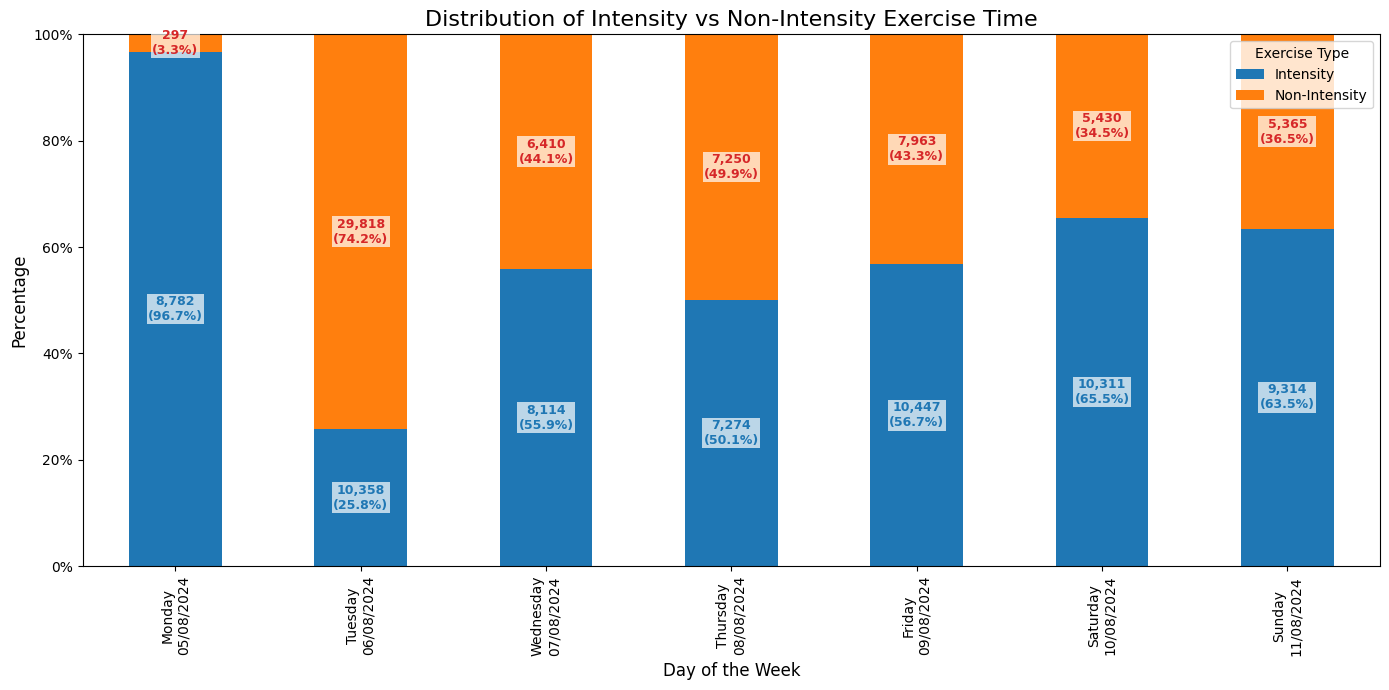

In [126]:
# Calculate total minutes and intensity minutes
total_minutes = df_daily[['Moving Time (min)', 'Intensity Time (min)']].max(axis=1).resample("D").sum()
intensity_minutes = df_daily['Intensity Time (min)'].resample("D").sum()
intensity_minutes.index = df_daily.resample("D").sum().index.strftime("%A\n%d/%m/%Y")
total_minutes.index = df_daily.resample("D").sum().index.strftime("%A\n%d/%m/%Y")

# Calculate intensity percentage
intensity_percentage = intensity_minutes / total_minutes

# Calculate non-intensity minutes and percentage
non_intensity_minutes = total_minutes - intensity_minutes
non_intensity_percentage = 1 - intensity_percentage

# Create a DataFrame with both minutes and percentages
df_data = pd.DataFrame({
    'Intensity': intensity_percentage,
    'Non-Intensity': non_intensity_percentage,
    'Intensity Minutes': intensity_minutes,
    'Non-Intensity Minutes': non_intensity_minutes
})

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
df_data[['Intensity', 'Non-Intensity']].plot(kind='bar', stacked=True, ax=ax)

# Define colors for the bars and text
colors = ['#1f77b4', '#ff7f0e']  # Orange for Intensity, Blue for Non-Intensity
text_colors = ['#1f77b4', '#d62728']  # Darker orange for Intensity text, Blue for Non-Intensity

# Function to create label text
def make_label(minutes, percentage):
    return f'{minutes:,.0f}\n({percentage:.1%})'

# Add labels on each bar segment
for i, container in enumerate(ax.containers):
    labels = [make_label(minutes, percentage) for minutes, percentage in 
              zip(df_data[f'{"Intensity" if i == 0 else "Non-Intensity"} Minutes'], container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center', 
                 fontweight='bold', fontsize=9, color=text_colors[i],
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

# Customize the plot
ax.set_title("Distribution of Intensity vs Non-Intensity Exercise Time", fontsize=16)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
ax.legend(title="Exercise Type", fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

# Set y-axis to display as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Ensure the y-axis goes from 0 to 100%
ax.set_ylim(0, 1)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

### Run vs Bike distance

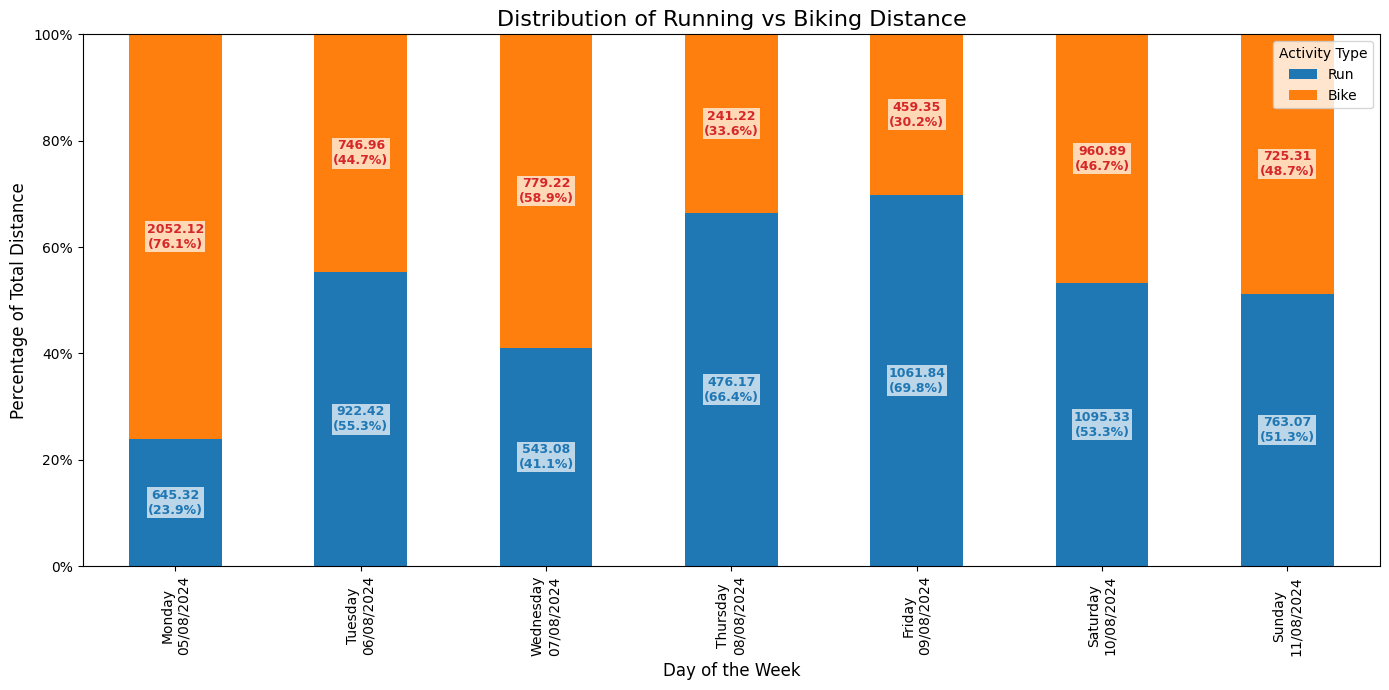

In [130]:
# Calculate total distance and individual distances for running and biking
total_distance = df_daily[['Run Distance (km)', 'Bike Distance (km)']].sum(axis=1).resample("D").sum()
run_distance = df_daily['Run Distance (km)'].resample("D").sum()
bike_distance = df_daily['Bike Distance (km)'].resample("D").sum()

# Format the index to show day of week and date
index_format = df_daily.resample("D").sum().index.strftime("%A\n%d/%m/%Y")
total_distance.index = run_distance.index = bike_distance.index = index_format

# Calculate percentages
run_percentage = run_distance / total_distance
bike_percentage = bike_distance / total_distance

# Create a DataFrame with both distances and percentages
df_data = pd.DataFrame({
    'Run': run_percentage,
    'Bike': bike_percentage,
    'Run Distance': run_distance,
    'Bike Distance': bike_distance
})

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
df_data[['Run', 'Bike']].plot(kind='bar', stacked=True, ax=ax)

# Define colors for the bars and text
colors = ['#ff7f0e', '#1f77b4'][::-1]  # Orange for Run, Blue for Bike
text_colors = ['#d62728', '#1f77b4'][::-1]  # Darker orange for Run text, Blue for Bike text

# Function to create label text
def make_label(distance, percentage):
    return f'{distance:.2f}\n({percentage:.1%})'

# Add labels on each bar segment
for i, container in enumerate(ax.containers):
    labels = [make_label(distance, percentage) for distance, percentage in 
              zip(df_data[f'{"Run" if i == 0 else "Bike"} Distance'], container.datavalues)]
    ax.bar_label(container, labels=labels, label_type='center', 
                 fontweight='bold', fontsize=9, color=text_colors[i],
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

# Customize the plot
ax.set_title("Distribution of Running vs Biking Distance", fontsize=16)
ax.set_xlabel("Day of the Week", fontsize=12)
ax.set_ylabel("Percentage of Total Distance", fontsize=12)
ax.legend(title="Activity Type", fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

# Set y-axis to display as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Ensure the y-axis goes from 0 to 100%
ax.set_ylim(0, 1)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.show()

## Workouts analysis

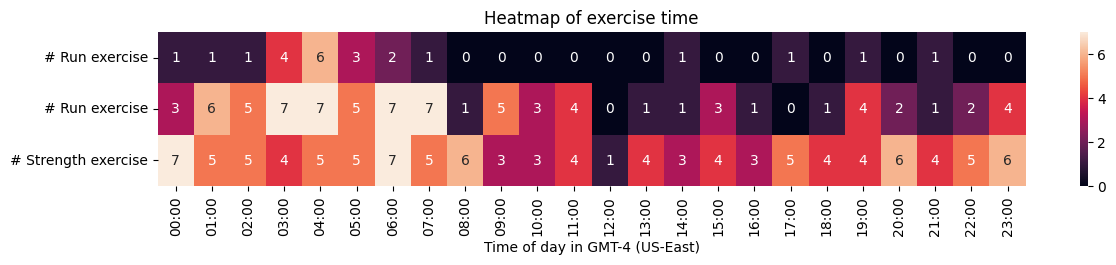

In [218]:
workout_stats = (df.diff().fillna(df).astype(int).drop(
    ["total_participants", "total_intensity_time", "total_moving_time"], axis=1
) == 0).astype(int)
workout_stats["hour"] = workout_stats.index.strftime("%H").map(lambda x: f"{x}:00")

fig, ax = plt.subplots(figsize=(14, 2))
sns.heatmap(
    workout_stats.groupby("hour").sum().rename(columns={
        "total_run_distance": "# Run exercise",
        "total_bike_distance": "# Run exercise",
        "total_strength_time": "# Strength exercise",
    }).T, 
    annot=True
)
ax.set_xlabel("Time of day in GMT-4 (US-East)")
ax.set_title("Heatmap of exercise time")
plt.show()